In [1]:
import cv2
from PIL import Image
import torch
from torch.nn import functional as F
import numpy as np

In [2]:
def gauss_kernel(size=5, device=torch.device('cpu'), channels=3):
    kernel = torch.tensor([[1., 4., 6., 4., 1],
                           [4., 16., 24., 16., 4.],
                           [6., 24., 36., 24., 6.],
                           [4., 16., 24., 16., 4.],
                           [1., 4., 6., 4., 1.]])
    kernel /= 256.
    kernel = kernel.repeat(channels, 1, 1, 1)
    kernel = kernel.to(device)
    return kernel

def downsample(x, factor=2):
    return x[:, :, ::factor, ::factor]

def upsample(x, factor=2):
    return F.interpolate(x, scale_factor=factor, mode='bilinear', align_corners=False)
    # cc = torch.cat([x, torch.zeros(x.shape[0], x.shape[1], x.shape[2], x.shape[3], device=x.device)], dim=3)
    # cc = cc.view(x.shape[0], x.shape[1], x.shape[2]*2, x.shape[3])
    # cc = cc.permute(0,1,3,2)
    # print(cc.shape)
    # cc = torch.cat([cc, torch.zeros(x.shape[0], x.shape[1], x.shape[2], x.shape[3]*2, device=x.device)], dim=3)
    # cc = cc.view(x.shape[0], x.shape[1], x.shape[2]*2, x.shape[3]*2)
    # x_up = cc.permute(0,1,3,2)
    # return conv_gauss(x_up, 4*gauss_kernel(channels=x.shape[1], device=x.device))

def conv_gauss(img, kernel):
    img = torch.nn.functional.pad(img, (2, 2, 2, 2), mode='reflect')
    out = torch.nn.functional.conv2d(img, kernel.to(img.device), groups=img.shape[1])
    return out

def gaussian_laplacian_pyramid(img, kernel, loi=[1,4,8]):
    pyr_gau = [img]
    pyr_lap = []
    for i in range(1, len(loi)):
        filtered = conv_gauss(pyr_gau[-1], kernel)
        scale_factor = int(loi[i] / loi[i-1])
        down = downsample(filtered, factor=scale_factor)
        up = upsample(down, factor=scale_factor)
        diff = pyr_gau[-1]-up
        pyr_lap.append(diff)
        pyr_gau.append(down)
    pyr_lap.append(pyr_gau[-1])
    return pyr_gau, pyr_lap

In [6]:
alpha = Image.open("../data/syn/benchmark/comp_easy/pha/00001/00000/02.png").convert('L') 
alpha = torch.from_numpy(np.array(alpha)).unsqueeze(0).unsqueeze(0).float() / 255.0

In [77]:
kernel = gauss_kernel(channels=1)
pyr_gau, pyr_lap = gaussian_laplacian_pyramid(alpha, kernel, loi=[1,4,8])

In [93]:
Image.fromarray((pyr_gau[2][0, 0].numpy() * 255).astype('uint8')).save("os8.png")

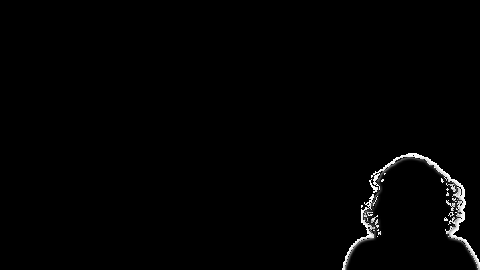

In [92]:
Image.fromarray((pyr_lap[1][0, 0].numpy() * 255).astype('uint8'))

In [84]:
# Reconstruct
pred = F.interpolate(pyr_gau[-1], scale_factor=2, mode='bilinear', align_corners=False) + pyr_lap[1]
pred = F.interpolate(pred, scale_factor=4, mode='bilinear', align_corners=False) + pyr_lap[0]

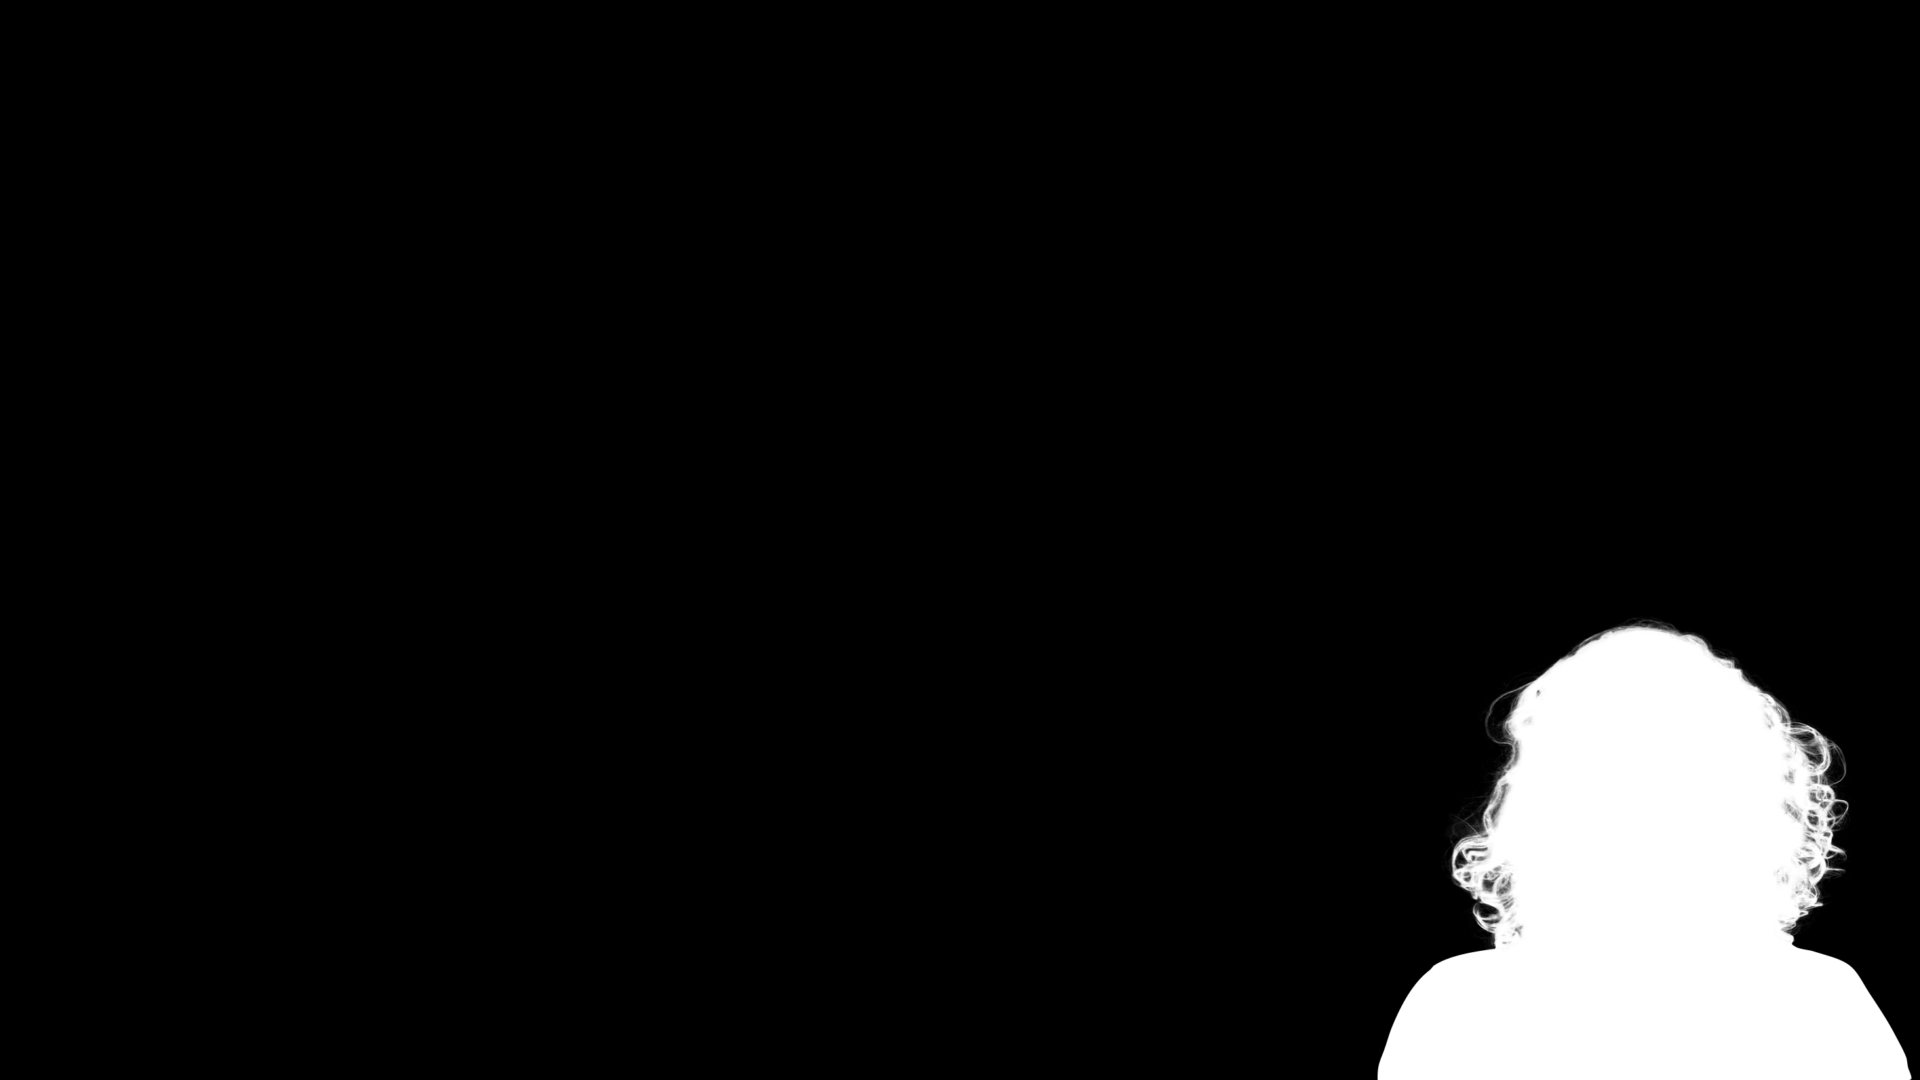

In [85]:
Image.fromarray((pred.clamp(0, 1) * 255).squeeze(0).squeeze(0).numpy().astype('uint8'))

In [94]:
torch.abs(pred - alpha).sum()

tensor(0.0005)

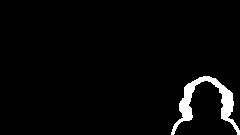

In [91]:
mask = (pyr_gau[2][0, 0] < 1.0) & (pyr_gau[2][0, 0] > 0.0)
Image.fromarray((mask.numpy() * 255).astype('uint8'))

In [95]:
# Reconstruct
pred = F.interpolate(pyr_gau[-1], scale_factor=2, mode='bilinear', align_corners=False)
mask = (pred < 1.0) & (pred > 0.0)
pred[mask] += pyr_lap[1][mask]
pred = F.interpolate(pred, scale_factor=4, mode='bilinear', align_corners=False) 
mask = (pred < 1.0) & (pred > 0.0)
pred[mask] += pyr_lap[0][mask]

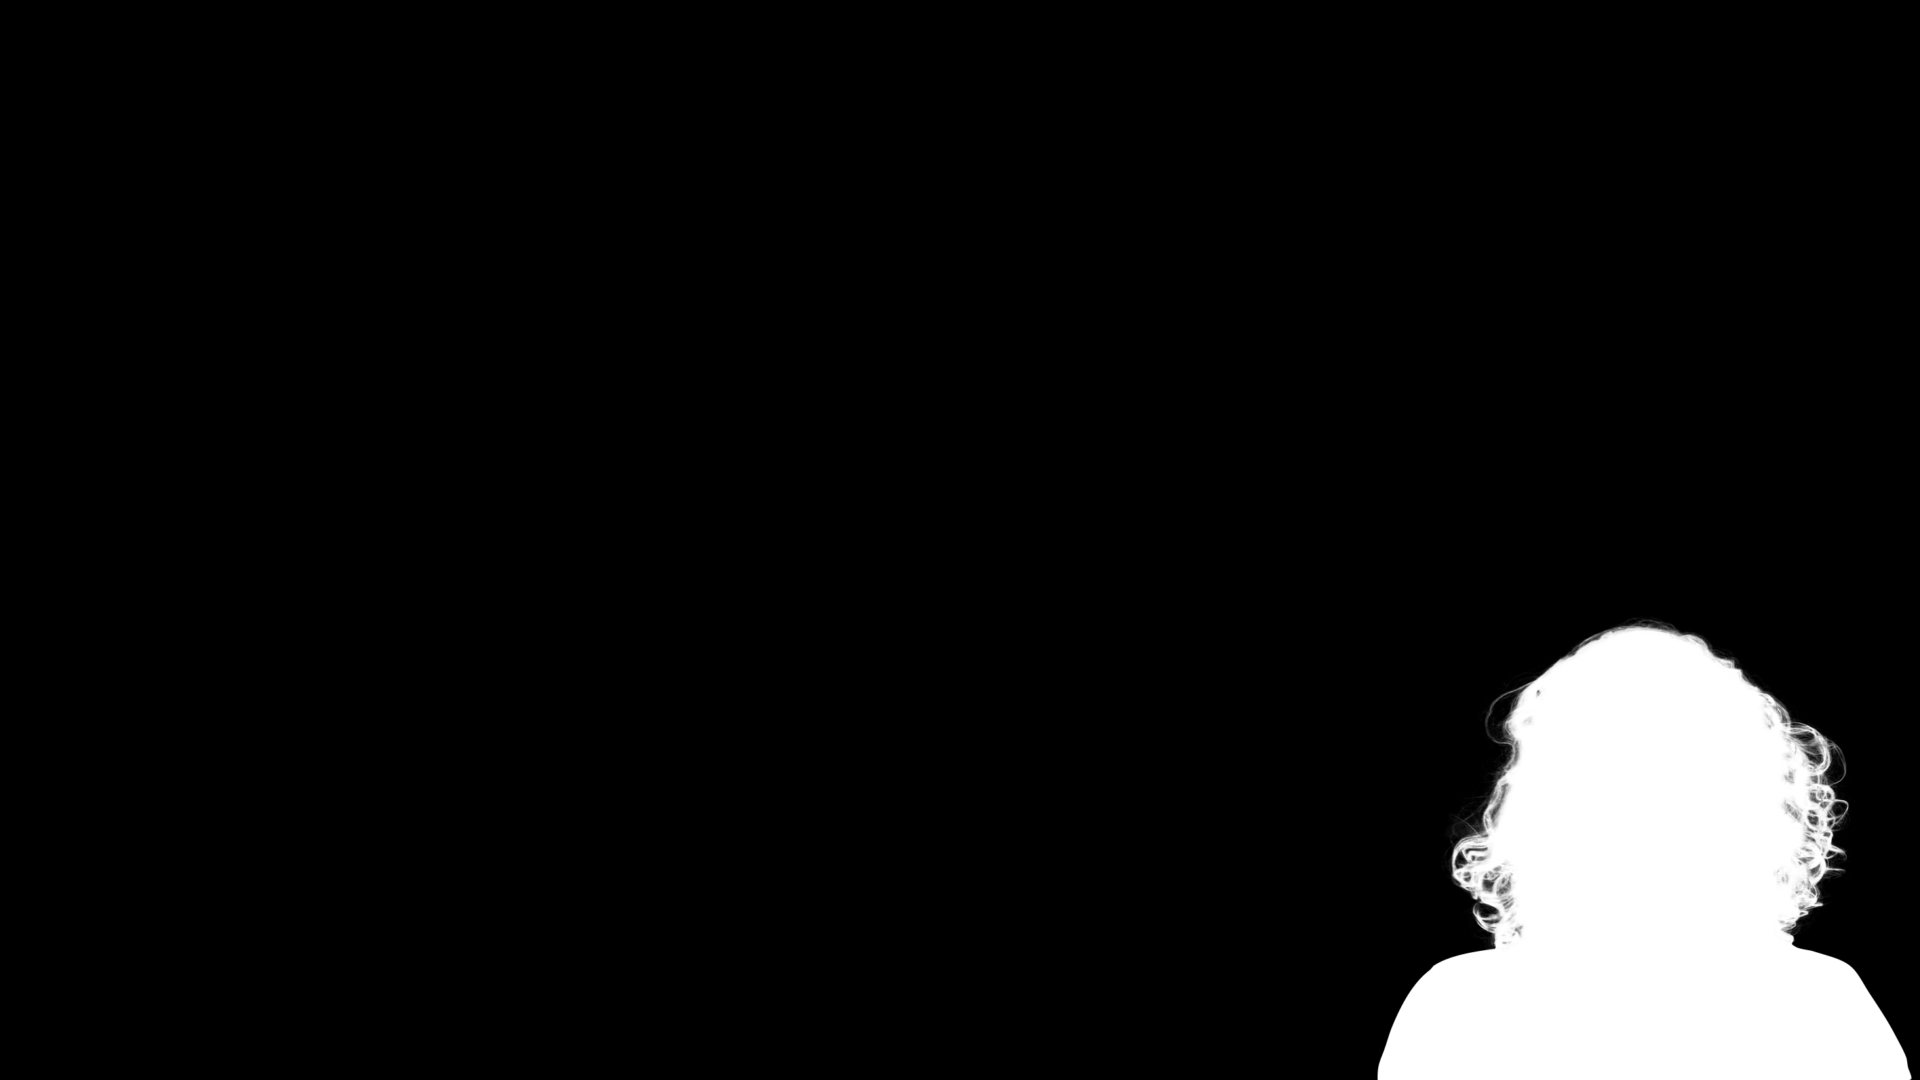

In [96]:
Image.fromarray((pred.clamp(0, 1) * 255).squeeze(0).squeeze(0).numpy().astype('uint8'))

In [97]:
torch.abs(pred - alpha).sum()

tensor(0.0005)

In [3]:
image = Image.open("../data/syn/benchmark/comp_easy/fgr/00001/00000.jpg")
image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0
image = image.unsqueeze(0)

In [4]:
im_kernel = gauss_kernel(channels=3)
im_pyrgau, im_pyrlap = gaussian_laplacian_pyramid(image, im_kernel, loi=[1,4,8])

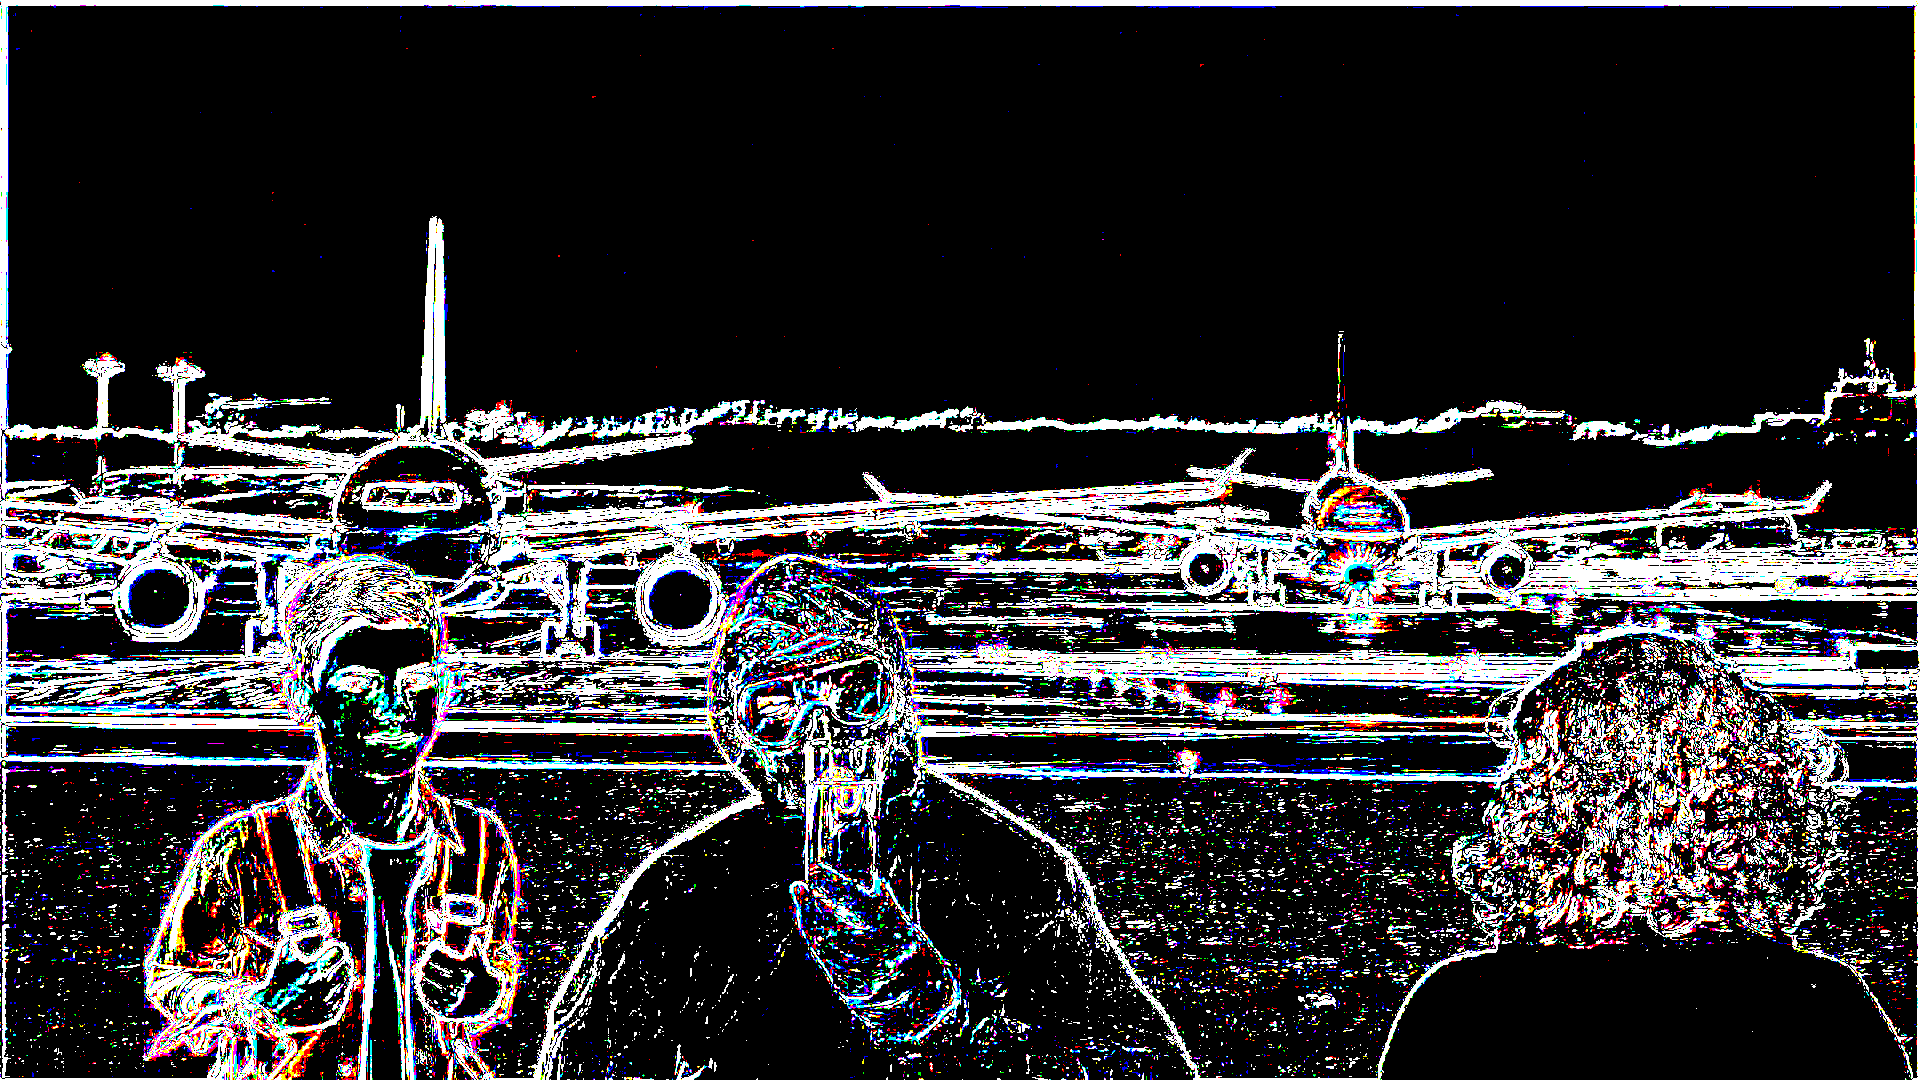

In [14]:
Image.fromarray(((im_pyrlap[0][0].permute(1,2,0).abs().numpy() > 0.02) * 255).astype('uint8'))

In [6]:
im_pyrlap[0][0].max()

tensor(0.5847)